Instrucciones

Base: 16b-Hex-to-centrality de guggenheim

1. Tomar nodos López Mateos (destino)
2. Tomar ¿Graph?, nodes y edges de aup.graph_from_hippo de nodos a 2km (origen)
3. aup.to_igraph con nodes y edges del buffer
4. seeds dest y seeds org
5. Nearest centrality to route
6. routes_osmid list comprehension
7. celda 59

Necesitamos ig.Graph.get_shortests_paths

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np
import igraph as ig

import matplotlib.pyplot as plt
import seaborn as sns
import folium

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

2023-02-15 02:57:18 Configured OSMnx 1.1.1
2023-02-15 02:57:18 HTTP response caching is on


## Loading López Mateos and creating buffer

<AxesSubplot:>

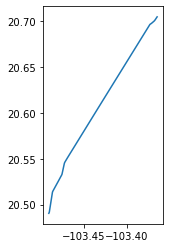

In [2]:
#Importing gdf with Avenue López Mateos as line 
lopezmateos_gdf = gpd.read_file("../../data/external/db_segundopiso_temp/lopezmateos.gpkg")
lopezmateos_gdf.plot()

<AxesSubplot:>

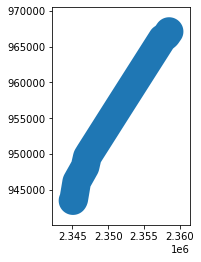

In [3]:
#Creating 2km buffer
lopezmateos_gdf_temp = lopezmateos_gdf.to_crs("EPSG:6372")
buffer_2km = lopezmateos_gdf_temp.buffer(2000)
buffer_2km.plot()

## Getting nodes from López Mateos

1. Getting edges and nodes from buffer_2km

In [4]:
#graph_from_hippo(gdf, schema, edges_folder='edges', nodes_folder='nodes')
graph_2kmgdf, nodes_2kmgdf, edges_2kmgdf = aup.graph_from_hippo(buffer_2km, 'osmnx', edges_folder='edges_speed', nodes_folder='nodes')

2023-02-15 02:58:29 Created graph from node/edge GeoDataFrames


In [5]:
edges_2kmgdf.head(1)

,,,osmid,oneway,lanes,name,highway,length,geometry,grade,grade_abs,access,tunnel,ref,maxspeed,bridge,junction,service,width,walkspeed,time_min
u,v,key,,,,,,,,,,,,,,,,,,,
4649110319,8764357413,0,727557563,False,None,None,unclassified,37.557,"LINESTRING (-103.49277 20.47597, -103.49247 20...",0.0,0.0,None,None,None,None,None,None,None,None,4.0,0.563355


2. From edges, find streets named like López Mateos

In [6]:
#Finding None values in 'name' and changing them to 'sin nombre'
#First we create a boolean mask where there is nan in 'name'
idx = edges_2kmgdf['name'].isna()
#Then, in that boolean mask, we change 'name' to 'sin nombre'
edges_2kmgdf.loc[idx, 'name'] = 'sin nombre'

In [7]:
#Finding streets named 'Mateos' (List comprehensions)
calles_lm_lst = [x for x in list(edges_2kmgdf.name.unique()) if 'Mateos' in x]
calles_lm_lst

['Lateral de López Mateos Sur',
 'Avenida Adolfo López Mateos Sur',
 'Avenida Adolfo López Mateos Norte',
 "['Avenida Adolfo López Mateos Norte', 'Avenida Adolfo López Mateos Sur']",
 "['Avenida Adolfo López Mateos Norte', 'Circunvalación Jorge Álvarez del Castillo']",
 'Calle López Mateos',
 "['Avenida Adolfo López Mateos Sur', 'Avenida López Mateos Sur']",
 'Avenida López Mateos Sur',
 'Farmacias Guadalajara López Mateos Sur',
 "['Autopista Guadalajara - Colima', 'Avenida López Mateos Sur']"]

<AxesSubplot:>

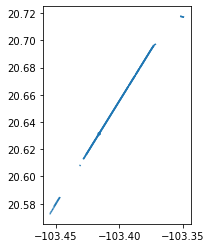

In [8]:
#Results: There're still missing lines. 
edges_2kmgdf.loc[edges_2kmgdf.name.isin(calles_lm_lst)].plot()

In [9]:
#Export to db to open in GIS and find missing lines
#aup.gdf_to_db_slow(edges_gdf,"edges_lopezmateos", 'segundopiso', if_exists='replace')

<AxesSubplot:>

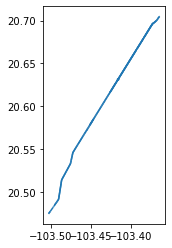

In [10]:
add_tolst = ['Autopista Guadalajara - Colima','Circunvalación Jorge Álvarez del Castillo']
for st in add_tolst:
    if st not in calles_lm_lst:
        calles_lm_lst.append(st)

remove_lst = ['Farmacias Guadalajara López Mateos Sur','Calle López Mateos']
for st in remove_lst:
    if st in calles_lm_lst:
        calles_lm_lst.remove(st)

#calles_lm_lst
edges_2kmgdf.loc[edges_2kmgdf.name.isin(calles_lm_lst)].plot()

In [11]:
edges_lm_gdf = edges_2kmgdf.loc[edges_2kmgdf.name.isin(calles_lm_lst)]
len(edges_lm_gdf)

845

3. From those lines, get the nodes

In [12]:
#The nodes are stored in the index of edges_lm_gdf
edges_index = edges_lm_gdf.index
edges_index

MultiIndex([(8407976153, 1760037166, 0),
            (8636724621, 8776027172, 0),
            (8636724626, 8636724621, 0),
            (1760037166, 8636724626, 0),
            (8407976154, 8407976153, 0),
            (1653526239, 6345478758, 0),
            (8317791436, 2882811501, 0),
            (6345478758, 8324054199, 0),
            (2882807997, 2882807994, 0),
            (2882811501, 1383913684, 0),
            ...
            (1207849850, 6345478759, 0),
            (6345478759, 3022414405, 0),
            (8324054199, 2882807995, 0),
            (2978021614, 1041108864, 0),
            (1041108864, 1347475658, 0),
            (1450183997, 8323161278, 0),
            (1347475658, 1450183997, 0),
            (2978021612, 6511832111, 0),
            (8323161278, 1041865204, 0),
            (8324161160, 1347454171, 0)],
           names=['u', 'v', 'key'], length=845)

In [13]:
#From each tupple of the multiindex we'll keep the first[0] and second[1] values.
nodes_lm_lst = []
for tupp in edges_index:
    if tupp[0] not in nodes_lm_lst:
        nodes_lm_lst.append(tupp[0])
    if tupp[1] not in nodes_lm_lst:
        nodes_lm_lst.append(tupp[1])
        
len(nodes_lm_lst)

851

In [14]:
nodes_lm_gdf = nodes_2kmgdf.loc[nodes_2kmgdf.index.isin(nodes_lm_lst)]
nodes_lm_gdf.head(1)

,x,y,street_count,geometry
osmid,,,,
283528400,-103.416184,20.630711,3,POINT (-103.41618 20.63071)


## Part 2

Input data for nearest route calculation

In [15]:
nodes_2km = nodes_2kmgdf.copy()
edges_2km = edges_2kmgdf.copy()
graph_2km = graph_2kmgdf.copy()
destiny_nodes = nodes_lm_gdf.copy()

Calculation

In [16]:
#convert to igraph to run the calculations
g, weights, node_mapping = aup.to_igraph(nodes_2km,edges_2km, "time_min") #time_min is what it will take into account to identify the shortest path

In [17]:
#seeds that will be used in ig.Graph.get_shortest_paths
nodes_2km = nodes_2km.reset_index() #For get_seeds to work we need osmid to be a column, not the index
destiny_nodes = destiny_nodes.reset_index() #For get_seeds to work we need osmid to be a column, not the index

seeds_dest = aup.get_seeds(destiny_nodes, node_mapping, 'osmid')
seeds_org = aup.get_seeds(nodes_2km, node_mapping, 'osmid')

In [18]:
shortest_path_len = g.shortest_paths_dijkstra(seeds_org, seeds_dest, weights=weights)
nearest_seed = np.array(shortest_path_len).argmin(axis=1)

In [20]:
#calculate shortest path
shortest_path_nodes = [ig.Graph.get_shortest_paths(g, seeds_org[i], seeds_dest[nearest_seed[i]], weights=weights) for i in range(len(seeds_org))]

/tmp/ipykernel_4289/337504445.py:2: RuntimeWarning: Couldn't reach some vertices at src/paths/dijkstra.c:441
  shortest_path_nodes = [ig.Graph.get_shortest_paths(g, seeds_org[i], seeds_dest[nearest_seed[i]], weights=weights) for i in range(len(seeds_org))]


In [21]:
keys_list = list(node_mapping)
routes_osmid = [[keys_list[shortest_path_nodes[x][0][i]] for i in range(len(shortest_path_nodes[x][0]))] for x in range(len(shortest_path_nodes))]
len(routes_osmid)

25470

In [22]:
edges_G = ox.graph_to_gdfs(graph_2km, nodes=False).reset_index().set_index(['u', 'v']).sort_index()

2023-02-15 03:21:16 Created edges GeoDataFrame from graph


In [23]:
i = 0 #count variable
mun = 'AMG' #metropolis

lines = []

for r in range(len(routes_osmid)):
    route_pairwise = zip(routes_osmid[r][:-1], routes_osmid[r][1:])
    
    for z in route_pairwise:
        try:
            osmid_touple = (z[0],z[1])
            lines.append(edges_G.loc[osmid_touple, ['osmid','geometry']].iloc[0])
        except:
            osmid_touple = (z[1],z[0])
            lines.append(edges_G.loc[osmid_touple, ['osmid','geometry']].iloc[0])
            
    i += 1
    if i==1 or i%1000==0 or i==(len(routes_osmid)):
        print('route',i,'finished')
        if i > 1:
            route_gdf = gpd.GeoDataFrame(lines)
            route_gdf = route_gdf.set_crs("EPSG:4326")
            #routes_join = route_gdf.rese/search?channel=fs&client=ubuntu&q=vensim+tutorialt_index().groupby(['level_0','level_1']).count()
            route_gdf.to_file(f'../../data/processed/lopezmateos_routes/{mun}_lm_route_{i}.geojson', driver='GeoJSON')
            lines = []

route 1 finished
route 1000 finished
route 2000 finished
route 3000 finished
route 4000 finished
route 5000 finished
route 6000 finished
route 7000 finished
route 8000 finished
route 9000 finished
route 10000 finished
route 11000 finished
route 12000 finished
route 13000 finished
route 14000 finished
route 15000 finished
route 16000 finished
route 17000 finished
route 18000 finished
route 19000 finished
route 20000 finished
route 21000 finished
route 22000 finished
route 23000 finished
route 24000 finished
route 25000 finished
route 25470 finished


### Grouping and cleaning routes

In [26]:
#Concatenating previously generated route files
gdf_routes = gpd.GeoDataFrame()
route_path = "../../data/processed/lopezmateos_routes/"

for f in os.listdir(route_path):
        if f.startswith(f'{mun}_lm_route_'):
            gdf_routes = gdf_routes.append(gpd.read_file(route_path+f, driver='GeoJSON'))
            
print(gdf_routes.shape)
gdf_routes.head(2)

(492030, 4)


,level_0,level_1,osmid,geometry
0,7824742432,1374116004,139215486,"LINESTRING (-103.40446 20.64759, -103.40453 20..."
1,7824742433,7824742417,"[ 838407352, 894834366 ]","LINESTRING (-103.40428 20.64779, -103.40435 20..."


In [27]:
#Grouping routes by osmid
grouped_routes = gdf_routes.groupby(['level_0','level_1']).count()
grouped_routes.reset_index(inplace=True)
grouped_routes.rename(columns={'osmid':'count'}, inplace=True)
grouped_routes.drop(columns=['geometry'], inplace=True)
print(grouped_routes.shape)
grouped_routes.head(5)

(24421, 3)


,level_0,level_1,count
0,28791285,1668893850,15
1,28791354,803055773,38
2,28791359,8347582312,47
3,28791397,1894163442,29
4,28791518,1473544273,1


In [29]:
#Merging grouped_routes with gdf_routes and dropping dupplicates
gdf_routes_diss = grouped_routes.reset_index().merge(gdf_routes, left_on=['level_0','level_1'],
                right_on=['level_0','level_1'], how='left')
gdf_routes_diss.drop_duplicates(inplace=True)
print(gdf_routes_diss.shape)
gdf_routes_diss.head(2)
gdf_routes_diss['count'].sum()

(24421, 6)


492030

### Saving file

In [31]:
gdf_routes_diss = gdf_routes_diss.set_crs("EPSG:4326")
aup.gdf_to_db_slow(gdf_routes_diss,"lopezmateos_routes", 'segundopiso', if_exists='replace')